**Pipeline Layout** 

1. Stage 1: feature engineering

2. Stage 2: feature elimination

3. Stage 3: Sampling methods for imbalanced classification

4. Stage 4: test-train-split

5. Stage 5: Apply specific classification model 

In [ ]:
## Import Libraries
import pandas as pd
import imblearn
import sys
import sklearn
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing as pp
from sklearn import pipeline 
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from pandas_profiling import ProfileReport

**ANOVA (Analysis of Variance) for feature elimination**

***recursive feature elimination***


Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.  -> ***chi2 statistic for elimination***

In [ ]:
#@title Preprocesing
"#@title"
# preprocessing libraries
from sklearn.feature_selection import VarianceThreshold , RFE,RFECV , chi2 , f_classif, SelectKBest, SelectFromModel 
from sklearn.linear_model import LogisticRegression

def preprocess_variance(df: pd.DataFrame , method) -> pd.DataFrame:
  # remove binary features which are 1/0 in > 80% data
  X = df.iloc[:,:37]
  y = df.iloc[:,:38]
  if (method == 'bernoulli'):
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    sel.fit_transform(X)
    return pd.DataFrame(X)
  if (method == 'chi2'):
    X_new = SelectKBest(chi2, k=20).fit_transform(X, y)
    return pd.DataFrame(X_new)
  if (method == 'f_classif'):
    X_new = SelectKBest(f_classif, k=20).fit_transform(X, y)
    return pd.DataFrame(X_new)
  if (method == 'RFE'):
    estimator = Logistic_Regression()
    selector = RFE(estimator, n_features_to_select=30, step=1)
    selector = selector.fit(X, y)
    selector.get_support
    pass

In [ ]:
# Preprocessing

# allowable upper age limit
AGE_THRESH = 120
# calculate today's date
TODAY = pd.to_datetime('today').normalize()
# create a list of column names that are dates
COLUMN_DATES = ['customer_since_all', 'customer_since_bank', 'customer_birth_date']
# Columns whose values we want to bin
COLUMN_BALANCES_CAPS = ['bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 
'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 
'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account', 
'bal_savings_account_starter', 'bal_current_account_starter']

# calculate today's date
TODAY = pd.to_datetime('today').normalize()
# create a list of column names that are dates
COLUMN_DATES = ['customer_since_all', 'customer_since_bank', 'customer_birth_date']

def calculate_age(x):
    if pd.isna(x):
        return np.nan
    else:
        # Return the age of a person by subtracting the birthdate from the current date
        birthdate = pd.to_datetime(x, format="%Y-%m")
        age_delta = TODAY - birthdate
        age = round(age_delta / pd.Timedelta(365, 'd'))
        return age
        
# Convert all non-numerical values to int64 (scaled)
# NaNs will be interpolated according to argument
def preprocess_dataframe(df: pd.DataFrame , key) -> pd.DataFrame:
    df.drop_duplicates(inplace=True)
    # remove client id column since it's not useful after dropping the duplicate values
    if key==1:
      df.drop(columns=['client_id'], inplace=True)
    for column_name in df:
        # print(f'column dtype: {df[column_name].dtype}, column_name: {column_name}')
        # If the column is an object, we need to map the string values to numerical values
        # or in the case of dates we need to convert them to age.
        
        if df[column_name].dtype == 'O':
            if column_name in COLUMN_DATES:
                # replace irregular values as NaNs to interpolate them later
                # make sure that we replace irregularities in customer_since_bank
                # and customer_since_all as well.
                df[column_name] = df[column_name].apply(calculate_age)
                if column_name == 'customer_birth_date':
                    df.loc[df['customer_birth_date'] >= AGE_THRESH, 'customer_birth_date'] = np.nan
                continue
            unique_values = pd.Series(df[column_name].unique()).dropna()
            # print(unique_values)
            # string entries to numerical entries example ['male', 'female'] -> [0, 1]
            # create empty dict to put unique values with the values that we'll map them
            mapping_dict = {}
            for idx, val in unique_values.items():
                mapping_dict.update({val: idx})
            df[column_name] = df[column_name].map(mapping_dict)
    # interpolate and then forward and backward fill to fill values that were not interpolated
    # values that are not interpolated are the edge values 
    # df = df.interpolate(method='nearest').ffill().bfill()

    #variance preprocessing
    # df = preprocess_variance( df , method = 'bernoulli')
    print(df.shape)

    return df

def bin_birthdate(df: pd.DataFrame) -> pd.DataFrame:
  '''
  This function bins birthdates in the following age ranges and assigns them a numerical value
  '''
  bins = [0, 20, 30, 40, 50, 65, 130]
  df.loc[:, 'customer_birth_date'] = pd.cut(df['customer_birth_date'], bins=bins, labels=False)
  return df

def bin_customer_time(df: pd.DataFrame) -> pd.DataFrame:
  '''
  This function bins customer time in the following years ranges and assigns them a numerical value
  '''
  bins = [0, 2, 5, 10, 15, 25, 40, 80]
  df.loc[:, 'customer_since_all'] = pd.cut(df['customer_since_all'], bins=bins, labels=False)
  df.loc[:, 'customer_since_bank'] = pd.cut(df['customer_since_bank'], bins=bins, labels=False)
  return df

def bin_bal_cap(df: pd.DataFrame, nbins: int = 10) -> pd.DataFrame:
  '''
  This function bins balance and caps values into bins (default 10) and assigns them a numerical value
  '''
  for col in COLUMN_BALANCES_CAPS:
    df.loc[:, col] = pd.cut(df[col], bins=nbins, labels=False)
  return df

def bin_postcode(pcode: pd.Series):
  '''
  This function bins postcodes according the number of zeros they include. 
  By searching on the internet it was found that postcodes with more zeros 
  are given to bigger cities
  '''
  pcode = pcode.map(str)
  return  pcode.apply(lambda x: x.count('0'))


def calculate_iv(X, y):
  '''
  This function calculates the information value (IV) for a given dataset.
  X: Features (pd.DataFrame)
  y: Targets (pd.Series)
  '''
  df = pd.concat([X, y], axis=1)

    # Predictive power and limits according to literature
  iv = {'predictive_power': ['useless (iv < 0.02)', 'weak (iv >= 0.02 & iv < 0.1)', 'medium (iv >= 0.1 & iv < 0.3)', 
        'strong (iv >= 0.3 & iv < 0.5)', 'too good to be true (iv > 0.5)'], 'column_name': ['', '', '', '', '']}
  df_iv = pd.DataFrame(iv)
  target = 'target'
  iv_dict = {}
  for c in df.columns:
        feature = c

        df_woe_iv = pd.crosstab(df[feature],df[target], normalize='columns')
        df_woe_iv = df_woe_iv.assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]+0.01))
        df_woe_iv = df_woe_iv.assign(iv=lambda dfx: np.sum(dfx['woe'] * (dfx[1] - dfx[0])))

        if df_woe_iv['iv'].iloc[0] < 0.02:
            df_iv.iloc[0].column_name += c + ', '
        elif df_woe_iv['iv'].iloc[0] >= 0.02 and df_woe_iv['iv'].iloc[0] < 0.1:
            df_iv.iloc[1].column_name += c + ', '
        elif df_woe_iv['iv'].iloc[0] >= 0.1 and df_woe_iv['iv'].iloc[0] < 0.3:
            df_iv.iloc[2].column_name += c + ', '
        elif df_woe_iv['iv'].iloc[0] >= 0.3 and df_woe_iv['iv'].iloc[0] < 0.5:
            df_iv.iloc[3].column_name += c + ', '
        else: 
            df_iv.iloc[4].column_name += c + ', '

        iv_dict.update({df_woe_iv.index.name : df_woe_iv['iv'].values[0]})

  iv_series = pd.Series(iv_dict)
  iv_series.drop(labels=['target'], inplace=True)
  return iv_series.sort_values(ascending=False)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Analytics'

In [ ]:
#@title Loading Data
# Data file
io = r"/train_month_3_with_target.csv"
io_test = r"/test_month_3.csv"

#past months
io_prev1 = r"/train_month_2.csv"
io_prev2 = r"/train_month_1.csv"
io_test_prev1 = r"/test_month_2.csv"  
io_test_prev2 = r"/test_month_1.csv"

#read and run preprocesing pipeline
#test data dataframes
df_test_ = pd.read_csv(path + io_test)
df_test_prev1 = pd.read_csv(path + io_test_prev1)
df_test_prev2 = pd.read_csv(path + io_test_prev2)
df_test_csv = df_test_.copy()
client_id = df_test_[['client_id']]

headers = pd.read_csv(path + io, nrows=0).columns.tolist()

headers_prev = pd.read_csv(path + io_prev1 , nrows = 0).columns.tolist()

#training dataset dataframes
df_ = pd.read_csv(path + io ,usecols= headers )
df_prev1_ = pd.read_csv(path + io_prev1 ,usecols= headers_prev )
df_prev2_ = pd.read_csv(path + io_prev2 ,usecols= headers_prev)

#preprocessing pipelines
#for train
df = preprocess_dataframe(df_  , key =1) #training_test_,month3 csv
df_prev1 = preprocess_dataframe(df_prev1_ , key = 1) #training_test_,month3 csv
df_prev2 = preprocess_dataframe(df_prev2_ , key = 1) #training_test_,month3 csv

# Bin balance and cap values
df = bin_bal_cap(df ,nbins=10)
df_prev1 = bin_bal_cap(df_prev1, nbins=10)
df_prev2 = bin_bal_cap(df_prev2, nbins=10)

# Bin customer birth date column
df = bin_birthdate(df)
df_prev1 = bin_birthdate(df_prev1)
df_prev2 = bin_birthdate(df_prev2)

# Bin customer_since_all and customer_since_bank columns
df = bin_customer_time(df)
df_prev1 = bin_customer_time(df_prev1)
df_prev2 = bin_customer_time(df_prev2)

# Bin postcodes
df.loc[:, 'customer_postal_code'] = bin_postcode(df['customer_postal_code'])
df_prev1.loc[:, 'customer_postal_code'] = bin_postcode(df_prev1['customer_postal_code'])
df_prev2.loc[:, 'customer_postal_code'] = bin_postcode(df_prev2['customer_postal_code'])

# Do the same for the test dataset
df_test = preprocess_dataframe(df_test_ , key=1)
df_test_prev1 = preprocess_dataframe(df_test_prev1 , key=1)
df_test_prev2 = preprocess_dataframe(df_test_prev2 , key=1)

# Bin balance and cap values
df_test = bin_bal_cap(df_test ,nbins=10)
df_test_prev1 = bin_bal_cap(df_test_prev1, nbins=10)
df_test_prev2 = bin_bal_cap(df_test_prev2, nbins=10)

# Bin customer birth date column
df_test = bin_birthdate(df_test)
df_test_prev1 = bin_birthdate(df_test_prev1)
df_test_prev2 = bin_birthdate(df_test_prev2)

# Bin customer_since_all and customer_since_bank columns
df_test = bin_customer_time(df_test)
df_test_prev1 = bin_customer_time(df_test_prev1)
df_test_prev2 = bin_customer_time(df_test_prev2)

# Bin postcodes
df_test.loc[:, 'customer_postal_code'] = bin_postcode(df_test['customer_postal_code'])
df_test_prev1.loc[:, 'customer_postal_code'] = bin_postcode(df_test_prev1['customer_postal_code'])
df_test_prev2.loc[:, 'customer_postal_code'] = bin_postcode(df_test_prev2['customer_postal_code'])

df_lin = df.interpolate(method = 'linear' , limit_direction = 'forward')
df_lin = pd.DataFrame(df_lin)
df_kInter = df.interpolate(method = 'nearest' ,order = 5 )
df_kInter = pd.DataFrame(df_kInter)

# df.drop(columns=['client_id' ], inplace=True)# fill with median
df_imputeMean = df.copy()
df_imputeMean.fillna(df.mean(), inplace=True)

# or impute with knn  --  remove target from 
imp = IterativeImputer(max_iter=10, random_state=0)

# fit iterative imputer on TT , TT-1, TT-2 features
df_imputed = pd.DataFrame(imp.fit_transform(df.iloc[:,:38]))
df_imputed2 = pd.DataFrame(imp.fit_transform(df_prev1.iloc[:,:38]))
df_imputed3 = pd.DataFrame(imp.fit_transform(df_prev2.iloc[:,:38]))

df_testImputed = pd.DataFrame(imp.fit_transform(df_test))
df_testImputed2 = pd.DataFrame(imp.fit_transform(df_test_prev1))
df_testImputed3 = pd.DataFrame(imp.fit_transform(df_test_prev2))

###imp.transform(df)

# polynomical features ---> under construction
poly = PolynomialFeatures(2) #2nd order features

(63697, 39)
(63697, 38)
(63697, 38)
(27300, 38)
(27300, 38)
(27300, 38)


In [ ]:
size_columns = 38 #feature space size

In [ ]:
# concatenate dataframes past month(feature tools engienering))
frames = [df_ , df_prev1_ , df_prev2_ ]
df_concat = pd.concat(frames)

In [ ]:
!pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print(df_concat)

       homebanking_active  has_homebanking  has_insurance_21  \
0                       0                0                 0   
1                       1                1                 0   
2                       1                1                 0   
3                       0                0                 0   
4                       0                0                 0   
...                   ...              ...               ...   
63692                   1                1                 1   
63693                   0                0                 1   
63694                   0                1                 0   
63695                   0                0                 0   
63696                   1                1                 0   

       has_insurance_23  has_life_insurance_fixed_cap  \
0                     0                             0   
1                     0                             0   
2                     0                             0   
3  

In [ ]:
import featuretools as ft
from featuretools.primitives import Max,Min,Skew,CumMax,CumMin
dataframes = {
    "df_conc" : (df_concat, "id"),
    "df_test_" : (df_test_ , "id")

}
es = ft.EntitySet(dataframes = dataframes)

ft.get_valid_primitives(entityset = es, target_dataframe_name = "df_test_", max_depth=2, selected_primitives=None)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="df_test_",
                                      agg_primitives=['Max','Min','Skew'],
                                      max_depth = None)
feature_matrix
feature_defs
ft.primitives.list_primitives()

In [ ]:
import featuretools as ft
from featuretools.primitives import 
dataframes = {
    "df_conc" : (df_concat, "id"),
    "df_test_" : (df_test_ , "id")

}
es = ft.EntitySet(dataframes = dataframes)

feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_dataframe_name="df_test_",
                                      agg_primitives=['Max','Min','Skew','CumMax','CumMin'],
                                      max_depth = None)
feature_matrix
feature_defs
ft.primitives.list_primitives()

**Feature Engineering with Past Months**
---
1. Include all features  
2. Include 1 month balance differnece

In [ ]:
# #@title Feature engineering additional predictions -- one-month balance differences
# filter_col = [col for   

# for i in range(len(filter_col)):
#   idx = (df.columns.get_loc(filter_col[i])) #get_filtered_col indices from preprocessed dataframe
#   cols_1 = df_imputed.iloc[:, idx]  #extract columns with client balances from train_test_1 TT
#   cols_2 = df_imputed2.iloc[:, idx] #train_test_2 TT-1
#   cols_3 = df_imputed3.iloc[:, idx] #train_test_3 TT-2
#   #balance difference features
#   feature_1 = cols_1 - cols_2
#   feature_2 = cols_2 - cols_3

#   #add features of 1-month differnce in balance balances
#   df_imputed.insert(size_columns , "Difference{}".format(i) , value = feature_1)
#   df_imputed.insert(size_columns , "Difference_2{}".format(i) , value = feature_2) 



In [ ]:
# # same for test
# for i in range(len(filter_col)):
#   idx = (df.columns.get_loc(filter_col[i])) #get_filtered_col indices from preprocessed dataframe
#   cols_1 = df_testImputed.iloc[:, idx]  #extract columns with client balances from train_test_1 TT
#   cols_2 = df_testImputed2.iloc[:, idx] #train_test_2 TT-1
#   cols_3 = df_testImputed3.iloc[:, idx] #train_test_3 TT-2
#   #balance difference features
#   feature_1 = cols_1 - cols_2
#   feature_2 = cols_2 - cols_3

#   #add features of 1-month differnce in balance balances
#   df_testImputed.insert(size_columns , "Difference{}".format(i) , value = feature_1)
#   df_testImputed.insert(size_columns , "Difference_2{}".format(i) , value = feature_2) 

#   #remove balance features from dataframe/ train,test
#   # df_imputed.drop(idx , axis=1 ,inplace = True)
#   # df_testImputed.drop(idx, axis=1 ,inplace = True)


In [ ]:
print(df_imputed)

In [ ]:
#@title Feature engineering additional predictions -- one-month balance differences- inlcude all previous months features
filter_col = [col for col in df_prev1] #select all client balance columns

balance_added_N = 2*len(filter_col) #dded 2*balanced_added_N features in tot.
print(balance_added_N)

for i in range(len(filter_col)):
  idx = (df.columns.get_loc(filter_col[i])) #get_filtered_col indices from preprocessed dataframe
  # cols_1 = df_imputed.iloc[:, idx]  #extract columns with client balances from train_test_1 TT
  cols_2 = df_imputed2.iloc[:, idx] #train_test_2 TT-1
  cols_3 = df_imputed3.iloc[:, idx] #train_test_3 TT-2
  #balance difference features
  # feature_1 = cols_1 
  feature_2 = cols_2 
  feature_3 = cols_3

  #add features of 1-month differnce in balance balances
  # df_imputed.insert(size_columns , "feature{}".format(i) , value = feature_1)
  df_imputed.insert(size_columns , "feature_2{}".format(i) , value = feature_2)
  df_imputed.insert(size_columns , "feature_3{}".format(i) , value = feature_3)

In [ ]:
#@title Feature engineering additional predictions -- one-month balance differences- inlcude all previous months features
filter_col = [col for col in df_test_prev1] #select all client balance columns

balance_added_N = 2*len(filter_col) #added 2*balanced_added_N features in tot.
print(balance_added_N)

for i in range(len(filter_col)):
  idx = (df.columns.get_loc(filter_col[i])) #get_filtered_col indices from preprocessed dataframe
  # cols_1 = df_testImputed.iloc[:, idx]  #extract columns with client balances from train_test_1 TT
  cols_2 = df_testImputed2.iloc[:, idx] #train_test_2 TT-1
  cols_3 = df_testImputed3.iloc[:, idx] #train_test_3 TT-2
  #balance difference features
  # feature_1 = cols_1 
  feature_2 = cols_2 
  feature_3 = cols_3

  #add features of 1-month differnce in balance balances
  # df_testImputed.insert(size_columns , "feature{}".format(i) , value = feature_1)
  df_imputed.insert(size_columns , "feature_2{}".format(i) , value = feature_2)
  df_imputed.insert(size_columns , "feature_3{}".format(i) , value = feature_3)

In [ ]:
print(df_testImputed)

In [ ]:
#define train and target 
df_impute = pd.DataFrame(df_imputed) # shape = row x 38 columns (training features, no client_id, target)
df_testImputed = pd.DataFrame(df_testImputed)

X_train = df_impute.iloc[:,:] #df_impute = 37 training features, select all (target removed, client removed)
y = df.iloc[:,38].values # df = 39 cols , target = 39 (38 in 0-based), no cliend_id

X_test_csv = df_testImputed.iloc[:,:37]

In [ ]:
print(df_testImputed)

        0    1    2    3    4    5    6    7    8    9   ...    28    29   30  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  41.0  41.0  2.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  29.0  29.0  2.0   
2      0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  ...  29.0  17.0  1.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  44.0  13.0  1.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   8.0   8.0  2.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
27295  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  23.0  17.0  2.0   
27296  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   5.0   5.0  1.0   
27297  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  17.0   5.0  2.0   
27298  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  19.0  19.0  1.0   
27299  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  27.0  27.0  1.0   

         31      32   33   

In [ ]:
N_non_churners = (y[y==0].shape)
N_churners = (y[y==1].shape)

In [ ]:
print(df_impute) #for X_train

        0    1    2    3    4    5    6    7    8    9   ...    28    29   30  \
0      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  39.0  28.0  1.0   
1      1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   5.0   5.0  1.0   
2      1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  42.0  42.0  2.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  24.0   9.0  1.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  10.0  10.0  2.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
63692  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  24.0  24.0  2.0   
63693  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  33.0  33.0  2.0   
63694  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  ...  31.0  31.0  2.0   
63695  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   8.0   8.0  1.0   
63696  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  20.0  20.0  1.0   

         31      32   33   

In [ ]:
df_test_csv #for testing
df_test_csv = pd.DataFrame(df_test_csv) #for testing
print(df_test_csv)

                              client_id  homebanking_active  has_homebanking  \
0      ccf4cd93d5c32cd8a59809d54b4d53ac                   0                0   
1      56605a660d18549592653ff6941186f1                   0                0   
2      bda5f84c05e5695a7ec10550b457890f                   0                0   
3      a2f1c04bc3acf2222e658a897400798f                   0                0   
4      e83aadc3b0d25dbc12a35551afa25807                   0                0   
...                                 ...                 ...              ...   
27295  1a634b5cfe6dbf35e77ce6519c0e3939                   0                0   
27296  84b7af2ddbeb919ab238ef7e6a83936c                   0                0   
27297  c257c09e3f4445d67b52a1007b0205df                   0                0   
27298  fdd7a1b7e58f642a1fc4867b8f7cdf3a                   0                0   
27299  9b088b828fa94419c00175b6536857f9                   0                0   

       has_insurance_21  has_insurance_

In [ ]:
# df_impute needs to be a array for chi2
# return 20 best columns according to chi2 test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 , f_classif, SelectFpr

# extract 20 best
X_new_chi = SelectKBest(chi2 , k=20).fit_transform(df_impute, y)

out_feat = SelectKBest(chi2 , k=20)
print( out_feat)
# iddentify k=20  from 38 cols extracted feaures

#X_new_fclassif = SelectKBest(SelectFpr , k=20).fit_transform( df_impute , y)

# N_features = 

X_new_fclassif = SelectKBest(SelectFpr , k=20).get_feature_names_out
# X_new = SelectKBest(chi2 , k=20).fit_transform( df_impute, y)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer , precision_score

"""
from sklearn:: RFE - recursive feature elimination docs
byy considering smaller and smaller sets of features. First, the estimator is trained on the initial set
of features and the importance of each feature is obtained either through any 
specific attribute or callable. Then, the least important features are pruned from current set of features
"""
#make a copy for feature selection
df_copy = df_testImputed.copy()

scorer = make_scorer(precision_score)

# recursively eliminate 
estimator = LinearSVC(penalty='l2')

selector = RFE(estimator, n_features_to_select=20, step=1 )

selector = selector.fit(X_train, y)

X_new_RFE = selector.transform(X_train)

selector.support_
selector.ranking_

# extract 20 best
out_feat_names = selector.get_feature_names_out(input_features = df_copy.columns.values )
print(out_feat_names)

#remove features not in out_feature_names from X_test_csv df for nxt pipeline steps

In [ ]:
print(df_imputed)

        0    1    2    3    4    5    6    7    8    9   ...    28    29   30  \
0      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  39.0  28.0  1.0   
1      1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   5.0   5.0  1.0   
2      1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  42.0  42.0  2.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  24.0   9.0  1.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  10.0  10.0  2.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
63692  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  24.0  24.0  2.0   
63693  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  ...  33.0  33.0  2.0   
63694  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  ...  31.0  31.0  2.0   
63695  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   8.0   8.0  1.0   
63696  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  20.0  20.0  1.0   

         31      32   33   

          0         1         2         3         4         5         6   \
0   1.000000  0.836034  0.147394  0.031775  0.010467  0.370733  0.104131   
1   0.836034  1.000000  0.149420  0.031627  0.013904  0.370220  0.094235   
2   0.147394  0.149420  1.000000  0.078064  0.022879  0.141086  0.081825   
3   0.031775  0.031627  0.078064  1.000000  0.009844  0.018637  0.010987   
4   0.010467  0.013904  0.022879  0.009844  1.000000  0.028022  0.028556   
5   0.370733  0.370220  0.141086  0.018637  0.028022  1.000000  0.169939   
6   0.104131  0.094235  0.081825  0.010987  0.028556  0.169939  1.000000   
7   0.177037  0.174585  0.076953  0.008405  0.016094  0.169311  0.101415   
8   0.359048  0.343345  0.122980  0.021168  0.021009  0.697623  0.206701   
9   0.478934  0.521151  0.116664  0.027989  0.019411  0.252533  0.136196   
10  0.123796  0.126303  0.042391  0.040006  0.000320  0.078739  0.032210   
11 -0.029550 -0.051015  0.018108  0.003215  0.000148 -0.046940 -0.005541   
12  0.102035

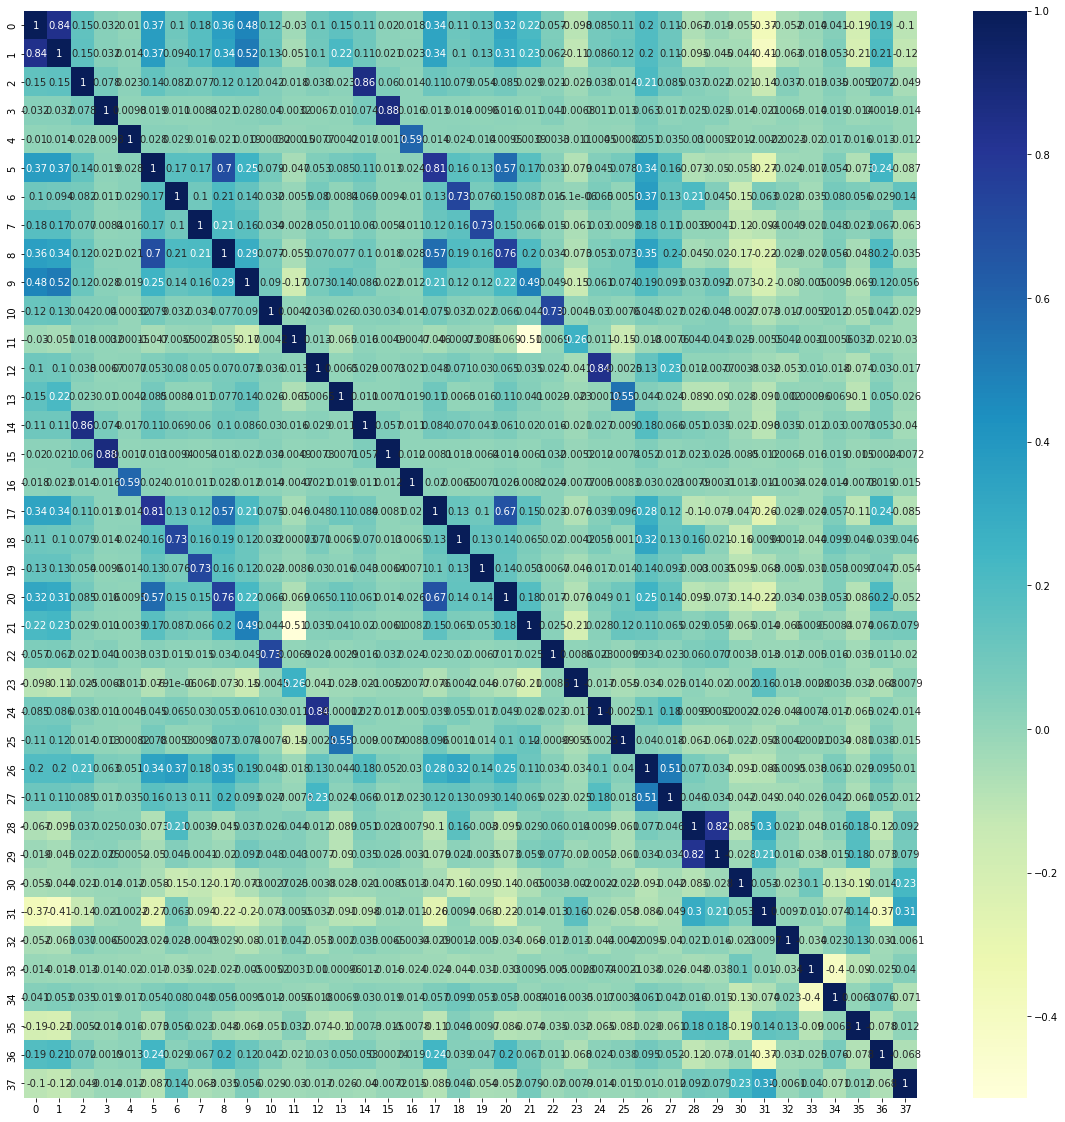

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
#remove correlated features from training csv
#using .corr method pandas.DataFrame

#compute correlation matrix for TT dataframe imputed,plot corr heatmap
df_corr = df_imputed.corr()
print(df_corr)
print(df_corr.shape)
plt.figure(figsize=(20,20))
sb.heatmap(df_corr, cmap="YlGnBu", annot=True)
plt.show()

#abs of corr matrix of imputed dataframe
cor_matrix = df_imputed.corr().abs()
cor_matrix2 = df_imputed2.corr().abs()
cor_matrix3 = df_imputed3.corr().abs()

upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri2 = cor_matrix2.where(np.triu(np.ones(cor_matrix2.shape),k=1).astype(np.bool))
upper_tri3 = cor_matrix3.where(np.triu(np.ones(cor_matrix3.shape),k=1).astype(np.bool))

#drop columns with high correlation
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

df_imputed = df.drop(df_imputed.columns[to_drop], axis=1)
df_imputed2 = df.drop(df_imputed2.columns[to_drop], axis=1)
df_imputed3 = df.drop(df_imputed3.columns[to_drop], axis=1)

In [ ]:
df_corr.idxmax(axis=1, skipna=True)

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
dtype: int64

In [ ]:
#@title RFECV feature selector
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE , RFECV

"""
from sklearn:: RFE - recursive feature elimination docs
byy considering smaller and smaller sets of features. First, the estimator is trained on the initial set
of features and the importance of each feature is obtained either through any 
specific attribute or callable. Then, the least important features are pruned from current set of features
"""
#make a copy for feature selection
df_copy = df_testImputed.copy()


# recursively eliminate 
estimator = LinearSVC(penalty='l2')

score_metric = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall'}

scores = cross_validate(
    estimator, X_train, y, cv=5, scoring=score_metric)

selector = RFECV(estimator, cv=5, min_features_to_select=10, importance_getter='auto',step=1, scoring = 'precision')

selector = selector.fit(X_train, y)

X_new_RFECV = selector.transform(X_train)

selector.support_
selector.ranking_

# extract 20 best
out_feat_names = selector.get_feature_names_out(input_features = df_copy.columns.values )
print(out_feat_names)

#remove features not in out_feature_names from X_test_csv df for nxt pipeline steps

In [ ]:
#isolate important features from RFE in test set
df_copy = df_copy.loc[:, out_feat_names]
print(df_copy)
X_test_csv = df_copy

        0    1    2    3    4    5    6    7    8    9   ...    28    29   30  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  41.0  41.0  2.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  29.0  29.0  2.0   
2      0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  ...  29.0  17.0  1.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  44.0  13.0  1.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   8.0   8.0  2.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...   
27295  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  23.0  17.0  2.0   
27296  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   5.0   5.0  1.0   
27297  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  17.0   5.0  2.0   
27298  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  ...  19.0  19.0  1.0   
27299  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  27.0  27.0  1.0   

         31      32   33   

In [ ]:
print(df_copy.columns.values)
print(out_feat_names)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37]


In [ ]:
for i in range (selector.ranking_.shape[0]):
    print(df.columns.values[i]) 
    print(selector.ranking_[i] , "")

homebanking_active
1 
has_homebanking
1 
has_insurance_21
1 
has_insurance_23
1 
has_life_insurance_fixed_cap
1 
has_life_insurance_decreasing_cap
1 
has_fire_car_other_insurance
1 
has_personal_loan
1 
has_mortgage_loan
1 
has_current_account
1 
has_pension_saving
1 
has_savings_account
1 
has_savings_account_starter
1 
has_current_account_starter
1 
bal_insurance_21
1 
bal_insurance_23
1 
cap_life_insurance_fixed_cap
1 
cap_life_insurance_decreasing_cap
1 
prem_fire_car_other_insurance
1 
bal_personal_loan
1 
bal_mortgage_loan
1 
bal_current_account
1 
bal_pension_saving
1 
bal_savings_account
1 
bal_savings_account_starter
1 
bal_current_account_starter
1 
visits_distinct_so
1 
visits_distinct_so_areas
1 
customer_since_all
1 
customer_since_bank
1 
customer_gender
1 
customer_birth_date
1 
customer_postal_code
1 
customer_occupation_code
1 
customer_self_employed
1 
customer_education
1 
customer_children
1 
customer_relationship
1 


In [ ]:
pd.DataFrame(df_imputed).columns.values

array(['homebanking_active', 'has_homebanking', 'has_insurance_21',
       'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap',
       'has_fire_car_other_insurance', 'has_personal_loan',
       'has_mortgage_loan', 'has_current_account', 'has_pension_saving',
       'has_savings_account', 'has_savings_account_starter',
       'has_current_account_starter', 'bal_insurance_21',
       'bal_insurance_23', 'cap_life_insurance_fixed_cap',
       'cap_life_insurance_decreasing_cap',
       'prem_fire_car_other_insurance', 'bal_personal_loan',
       'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving',
       'bal_savings_account', 'bal_savings_account_starter',
       'bal_current_account_starter', 'visits_distinct_so',
       'visits_distinct_so_areas', 'customer_since_all',
       'customer_since_bank', 'customer_gender', 'customer_birth_date',
       'customer_postal_code', 'customer_occupation_code',
       'customer_self_employed'

In [ ]:
from sklearn.feature_selection import SelectFromModel

"""
SelectFromModel is a transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_) or via an importance_getter callable after fitting
The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter. Apart from specifying the threshold numerically, there are built-in heuristics for finding a threshold using a string argumen
 combination with the threshold criteria, one can use the max_features parameter to set a limit on the number of features to select.
"""
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y)
model = SelectFromModel(lsvc, prefit=True)
X_new_ModelSelectLSVC = model.transform(X_train)
X_new_ModelSelectLSVC.shape

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


(63697, 11)

In [ ]:
# df_impute needs to be a array for chi2
# return 20 best columns according to chi2 test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 , f_classif, SelectFpr

"""
chi^2 method
"""
df_copy = df_test.copy()
df_copy.drop(columns=['client_id'], inplace=True)


# extract 20 best
SelectBest = SelectKBest(chi2 , k=20)
out_features = SelectBest.fit_transform(df_impute, y)

out_feat_names = SelectBest.get_feature_names_out(input_features = df_copy.columns.values )

print(out_feat_names)

In [ ]:
"""
False-Positive-Rate method
"""
# iddentify k=20  from 38 cols extracted feaures
X_new_fclassif = SelectKBest(SelectFpr , k=20).fit_transform( df_impute , y)

X_new_fclassif = SelectKBest(SelectFpr , k=20)
# X_new = SelectKBest(chi2 , k=20).fit_transform( df_impute, y)


In [ ]:
# df_impute needs to be a array for chi2
# return 20 best columns according to chi2 test
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 , f_classif, SelectFpr

# iddentify k=20  from 38 cols extracted feaures - ANOVA method
"""
ANOVA method
"""
#make a copy for feature selection
df_copy = df_test.copy()
df_copy.drop(columns=['client_id'], inplace=True)

X_new_fclassif = SelectKBest(f_classif , k=20)
X_new_fclassif.fit_transform(df_impute , y )

N_features_in = getattr(X_new_fclassif , 'n_features_in_')
# Feature_names = getattr(X_new_fclassif , 'feature_names_in')
print(N_features_in)

# X_new = SelectKBest(chi2 , k=20).fit_transform( df_impute, y)

# extract 20 best

out_feat_names = X_new_fclassif.get_feature_names_out(input_features = df_copy.columns.values )

print(out_feat_names)

In [ ]:
# results with reduced feature space with chi2 ranking
from sklearn.utils.class_weight import compute_class_weight

class_weight_vect = compute_class_weight( 'balanced' ,classes =  np.unique(y) , y= y)
print(class_weight_vect)

X_train = X_new_RFE

In [ ]:
"""
define x_train as per feature selector used per run
"""
#1.Feature select with RFE
X_train = X_new_RFE

In [ ]:
# remove the respective features from X_test_csv 
df3 = df_3.loc[:, df_3.columns != selector.ranking_[i]]
trainX_3 = df3.to_numpy()
#1. identify index/column values post feature selection

In [ ]:
# remove the respective features from X_test_csv 

# 1. Isolate the features array from initial dataframe and extract names
df2 = df.loc[:, df.columns != selector.ranking_]
trainX_2= df2.to_numpy()

In [ ]:
#imbalanced classification report - imblearn API  -- precision , recall , sensitiviy , geometric mean metrcis
# SMOTE from imblearn.over_sampling import SMOTE, ADASYN
# synthetic data aug for minority class
from imblearn.over_sampling import SMOTE, ADASYN    
from sklearn.metrics import confusion_matrix , accuracy_score, roc_auc_score,roc_curve,precision_recall_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

# print(x_valid.shape)
print(y.shape)
# print(y_valid.shape)

X_train = X_new_RFE

# scaling and normalization -> standardization scaler
scaler = pp.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test_csv = scaler.fit_transform(X_test_csv)

# test train split
X_new, X_test, y_new, y_test = train_test_split(
                X_train, y, test_size=0.33, random_state=42 ,stratify =y)

In [ ]:
# # # SMOTE oversampler

# # oversample validaiton set from test train split
# strat = 0.06 #sampling stragtegy for smote 
# sm=SMOTE(random_state=40 , sampling_strategy = strat)
# X_resampled, y_resampled = sm.fit_resample(X_new, y_new) #resample train the test train split datasets
# X_resampled_valid, y_resampled_valid = sm.fit_resample(X_test, y_test) #resample validation

# # resample smote on test
# # X_resampled_test = sm.fit_resample(X_test_csv)

# print(y_resampled)

# clf_smote = LogisticRegression().fit(X_resampled, y_resampled)#fit loggistic on valiation 

# #predict on validation and test data and print confusion matrices
# preds = clf_smote.predict(X_resampled_valid)
# preds_prob = clf_smote.predict_proba(X_resampled_valid)  #predictions and probs for  validation set
# preds_test = clf_smote.predict(X_test_csv)
# preds_prob_test = clf_smote.predict_proba(X_test_csv)  #predictions and probs for test set

# # print confusion matrices
# print("SMOTE confusion matrix validation")
# print(confusion_matrix(preds , y_resampled_valid , normalize ='true'))

# # print("SMOTE confusion matrix test")
# # print(confusion_matrix(preds_test , y , normalize ='true'))


# # define csv for output - uploads

# df_test.drop(columns=['client_id'], inplace=True)
# result = pd.concat([client_id, df_test], axis=1, join="inner")
# probabilities = preds_prob_test[:,1]

# finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
# finaldf.to_csv("final2.csv", index=False)

In [ ]:
# # # SMOTEENN oversampler
# from imblearn.over_sampling import KMeansSMOTE
# # oversample validaiton set from test train split
# strat = 0.05 #sampling stragtegy for smote 
# sm=KMeansSMOTE(random_state=40 , sampling_strategy = strat, cluster_balance_threshold= 0.1)
# X_resampled, y_resampled = sm.fit_resample(X_new, y_new) #resample train the test train split datasets
# X_resampled_valid, y_resampled_valid = sm.fit_resample(X_test, y_test) #resample validation

# # resample smote on test
# # X_resampled_test = sm.fit_resample(X_test_csv)

# print(y_resampled)

# clf_smote = LogisticRegression().fit(X_resampled, y_resampled)#fit loggistic on valiation 

# #predict on validation and test data and print confusion matrices
# preds = clf_smote.predict(X_resampled_valid)
# preds_prob = clf_smote.predict_proba(X_resampled_valid)  #predictions and probs for  validation set
# preds_test = clf_smote.predict(X_test_csv)
# preds_prob_test = clf_smote.predict_proba(X_test_csv)  #predictions and probs for test set

# # print confusion matrices
# print("SMOTE confusion matrix validation")
# print(confusion_matrix(preds , y_resampled_valid ))

# # print("SMOTE confusion matrix test")
# # print(confusion_matrix(preds_test , y , normalize ='true'))


# # define csv for output - uploads

# df_test.drop(columns=['client_id'], inplace=True)
# result = pd.concat([client_id, df_test], axis=1, join="inner")
# probabilities = preds_prob_test[:,1]

# finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
# finaldf.to_csv("final_smoteEENMN_log.csv", index=False)

In [ ]:
print(df_copy)

In [ ]:
# UNDERSAMPLING: define undersample strategy
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.3)

X_new = X_new_RFE
y_new = y

# Apply undersampling
X_resampled, y_resampled = undersample.fit_resample(X_new, y_new)

In [ ]:
# # ADASYN oversampler

# # oversample validaiton set from test train split
# strat = 0.05
# sm=ADASYN(random_state=40 ,sampling_strategy= strat)
# X_resampled, y_resampled = sm.fit_resample(X_new, y_new) #resample train the test train split datasets
# X_resampled_valid, y_resampled_valid = sm.fit_resample(X_test, y_test) #resample validation

# # resample smote on test
# # X_resampled_test = sm.fit_resample(X_test_csv)

# print(y_resampled)

# clf_smote = LogisticRegression().fit(X_resampled, y_resampled)#fit loggistic on valiation 

# #predict on validation and test data and print confusion matrices
# preds = clf_smote.predict(X_resampled_valid)
# preds_prob = clf_smote.predict_proba(X_resampled_valid)  #predictions and probs for  validation set
# preds_test = clf_smote.predict(X_test_csv)
# preds_prob_test = clf_smote.predict_proba(X_test_csv)  #predictions and probs for test set

# # print confusion matrices
# print("ADASYN confusion matrix validation")
# print(confusion_matrix(preds , y_resampled_valid , normalize ='true'))

# # print("SMOTE confusion matrix test")
# # print(confusion_matrix(preds_test , y , normalize ='true'))


# # define csv for output - uploads
# df_test.drop(columns=['client_id'], inplace=True)
# result = pd.concat([client_id, df_test], axis=1, join="inner")
# probabilities = preds_prob_test[:,1]

# finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
# finaldf.to_csv("final3.csv", index=False)

## Using different Classification methods to predict churners 

In [ ]:
# Random forest classification

''' Building the Random Forest classifier'''
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier as RF

def classifier_RandomForest(train_sbset, train_classes, valid_sbset, valid_classes, n_estimators):
    '''
        This function fits a Random Forest classifier to the given training subset.
    '''
    # Step 1: Training the classifier (clf)
    ###  n_estimators: The number of trees in the forest. (default=100)
    ###  bootstrap:    Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. (default=True)
    ###  random_state: Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
    clf = RF(n_estimators, random_state = 17) # random_state = 17 simply sets seed to the random generator, so that the train-test splits are always deterministic. If you don't set seed, it is different each time.
    clf.fit(train_sbset, train_classes)

    # Take the predictions of the model
    train_predictions = clf.predict(train_sbset)     # Should be very similar to the training_labels
    valid_predictions = clf.predict(valid_sbset)

    # Calculate the accuracy
    train_acc = accuracy_score(train_classes, train_predictions) # Should be close to 1. If we have high accuracy in the training dataset and low accuracy in the test dataset it means our model is overfitting.
    valid_acc = accuracy_score(valid_classes, valid_predictions) # The more the merrier

    print("RF Training set accuracy: {:.2f}%" .format(100*train_acc))
    print("RF Validation set accuracy: {:.2f}%" .format(100*valid_acc))     
    
    return clf, train_predictions, valid_predictions


# run RF predictor with 39 trees
clf, train_prediction , valid_prediction = classifier_RandomForest(X_new , y_new , X_test , y_test , n_estimators = 39)

preds_valid_RF = clf.predict(X_test)
preds_test_RF = clf.predict(X_test_csv)
preds_prob_test_RF = clf.predict_proba(X_test_csv)  #predictions and probs for test set

# print validation confusion matrices
print("RF,39 confusion matrix validation")
print(confusion_matrix(preds_valid_RF , y_test , normalize ='true'))
probabilities = preds_prob_test_RF[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalRF39.csv", index=False)

# run RF predictor with 200 dts
clf, train_prediction , valid_prediction = classifier_RandomForest(X_new , y_new , X_test , y_test , n_estimators = 200)

preds_valid_RF_200 = clf_smote.predict(X_test)
preds_test_RF_200 = clf.predict(X_test_csv)
preds_prob_test_RF_200 = clf.predict_proba(X_test_csv)  #predictions and probs for test set

# print validation confusion matrices
print("RF,200 confusion matrix validation")
print(confusion_matrix(preds_valid_RF_200 , y_test, normalize ='true'))
probabilities = preds_prob_test_RF_200[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalRF200.csv", index=False)

In [ ]:
X_resampled = X_new
y_resampled = y

In [ ]:
# RF with oversampled SMOTE 
clf, train_prediction , valid_prediction = classifier_RandomForest(X_resampled , y_resampled , X_test , y_test , n_estimators = 39)


preds_valid_RF = clf.predict(X_test)
preds_train_RF = clf.predict(X_resampled)
preds_test_RF = clf.predict(X_test_csv)
preds_prob_test_RF = clf.predict_proba(X_test_csv)  #predictions and probs for test set

# print validation confusion matrices
print("RF,39 confusion matrix validation")
print(confusion_matrix(preds_valid_RF, y_test  ))
probabilities = preds_prob_test_RF[:,1]
# define csv for output - uploads
# df_test.drop(columns=['client_id'], inplace=True)
result = pd.concat([client_id, df_test], axis=1, join="inner")
probabilities = preds_prob_test_RF[:,1]

finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalrf39_SMOTE.csv", index=False)

In [ ]:
from sklearn.metrics import classification_report , precision_score

# presicion scores for RF classifier , n_estimator =39
#
train_pr_score = precision_score( y_new , preds_train_RF,) 
valid_pr_score = precision_score( y_test , preds_valid_RF ,)


print(train_pr_score)
print(valid_pr_score)

In [ ]:
from sklearn.metrics import classification_report , precision_score
# print(classification_report(preds_valid_RF_200 , y_test))

train_pr_score = precision_score( y_new , preds_train_RF_200) 
valid_pr_score = precision_score( y_test , preds_valid_RF_200)


print(train_pr_score)
print(valid_pr_score)

In [ ]:
# boosted random forest 
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# define model
model = XGBClassifier()
# define grid
weights = [50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_new, y_new)  #perform grid search on validation data
# report the best configuration --> xgboost trees
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# fit
model.fit(X_new , y_new)

In [ ]:
# Random forest classification
from xgboost import XGBClassifier

''' Building the Random Forest classifier'''
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier as RF

def classifier_RandomForest(train_sbset, train_classes, valid_sbset, valid_classes, n_estimators):
    '''
        This function fits a Random Forest classifier to the given training subset.
    '''
    # Step 1: Training the classifier (clf)
    ###  n_estimators: The number of trees in the forest. (default=100)
    ###  bootstrap:    Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree. (default=True)
    ###  random_state: Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).
    clf = XGBClassifier(n_estimators, random_state = 17 , scale_pos_weight=50) # random_state = 17 simply sets seed to the random generator, so that the train-test splits are always deterministic. If you don't set seed, it is different each time.
    clf.fit(train_sbset, train_classes)

    # Take the predictions of the model
    train_predictions = clf.predict(train_sbset)     # Should be very similar to the training_labels
    valid_predictions = clf.predict(valid_sbset)

    # Calculate the accuracy
    train_acc = accuracy_score(train_classes, train_predictions) # Should be close to 1. If we have high accuracy in the training dataset and low accuracy in the test dataset it means our model is overfitting.
    valid_acc = accuracy_score(valid_classes, valid_predictions) # The more the merrier

    print("RF Training set accuracy: {:.2f}%" .format(100*train_acc))
    print("RF Validation set accuracy: {:.2f}%" .format(100*valid_acc))     
    
    return clf, train_predictions, valid_predictions


# run xgb predictor with 39 dts
clf, train_prediction , valid_prediction = classifier_RandomForest(X_new , y_new , X_test , y_test , n_estimators = 39)


preds_valid_xgb = clf_smote.predict(X_test)
preds_test_xgb = clf_smote.predict(X_test_csv)
preds_prob_test_xgb = clf_smote.predict_proba(X_test_csv)  #predictions and probs for test set

# print validation confusion matrices
print("xgb,39 confusion matrix validation")
print(confusion_matrix( y_test ,preds_valid_xgb , normalize ='true'))
probabilities = preds_prob_test_xgb[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalxgb39.csv", index=False)

# run xgb predictor with 200 dts
clf, train_prediction , valid_prediction = classifier_RandomForest(X_new , y_new , X_test , y_test , n_estimators = 200)

preds_valid_xgb_200 = clf_smote.predict(X_test)
preds_test_xgb_200 = clf.predict(X_test_csv)
preds_prob_test_xgb_200 = clf.predict_proba(X_test_csv)  #predictions and probs for test set

# print validation confusion matrices
print("xgb,200 confusion matrix validation")
print(confusion_matrix( y_test,preds_valid_xgb_200 , normalize ='true'))
probabilities = preds_prob_test_xgb_200[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalxgb200.csv", index=False)

In [ ]:

# run xgb predictor with 39 dts
clf, train_prediction , valid_prediction = classifier_RandomForest(X_resampled , y_resampled , X_test , y_test , n_estimators = 39)

preds_valid_RF = clf.predict(X_test)
preds_train_RF = train_prediction
preds_test_RF = clf.predict(X_test_csv)
preds_prob_test_RF = clf.predict_proba(X_test_csv)  #predictions and probs for test set

# print validation confusion matrices
print("RF,39 confusion matrix validation")
print(confusion_matrix(preds_valid_RF, y_test ))
probabilities = preds_prob_test_RF[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalrf39_SMOTE.csv", index=False)

In [ ]:
from re import X
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score , recall_score , precision_score , make_scorer
# X_resampled = X_new  # without resampling for logistic regression with class_weights
# y_resampled = y_new

scorers = {
    
    'precision_score' : make_scorer(precision_score),
    'recall_score' : make_scorer(recall_score),
    'accuracy_score' : make_scorer(accuracy_score)

}
# clf_log = CalibratedClassifierCV(method = 'isotonic', cv=3).fit(X_resampled , y_resampled)
callib_classSVC = CalibratedClassifierCV()
param_grid = { 'method' : ['isotonic' , 'sigmoid']}
clf = GridSearchCV(callib_classSVC, param_grid, scoring=scorers, n_jobs = -1 , refit = 'precision_score') #n_jobs=parallelization
clf.fit(X_train, y)
sorted(clf.cv_results_.keys())

preds_valid_log = clf_log.predict(X_test)
preds_train_log = clf_log.predict(X_train)
preds_test_log = clf_log.predict(X_test_csv)
preds_prob_test_log = clf_log.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y , preds_train_log ))

train_pres = precision_score(y , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log ))

result = pd.concat([client_id, df_test], axis=1, join="inner")

probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalSVMCallibratedPredictions_undersamp1000.csv", index=False)

In [ ]:
preds_valid_log = clf.predict(X_test)
preds_train_log = clf.predict(X_train)
preds_test_log = clf.predict(X_test_csv)
preds_prob_test_log = clf.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y , preds_train_log ))

train_pres = precision_score(y , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log ))

result = pd.concat([client_id, df_test], axis=1, join="inner")

probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalSVMCallibratedPredictions_undersamp1000.csv", index=False)

In [ ]:
sorted(clf.cv_results_.keys())

In [ ]:
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score
clf_rf = BalancedRandomForestClassifier(n_estimators=100, criterion='gini' , max_depth=3, random_state=0)
clf_rf.fit(X_resampled , y_resampled)

preds_valid_log = clf_rf.predict(X_test)
preds_train_log = clf_rf.predict(X_resampled) #x_new = train set
preds_test_log = clf_rf.predict(X_test_csv)
preds_prob_test_log = clf_rf.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log))

result = pd.concat([client_id, df_test], axis=1, join="inner")

probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finallog_BalancedRF.csv", index=False)

print("Train-validation presicion scores for balancedRF - imblearn API")
train_pr_score = precision_score( y_resampled , preds_train_log) 
valid_pr_score = precision_score( y_test , preds_valid_log)

print(train_pr_score)
print(valid_pr_score)

In [ ]:
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
scorers = {
    'precision_score' : make_scorer(precision_score),
    'recall_score' : make_scorer(recall_score),
    'accuracy_score' : make_scorer(accuracy_score)
}

#balanced RF model - grid search
clf_rf = BalancedRandomForestClassifier()
param_grid={'n_estimators':[int(x) for x in np.linspace(start=50,stop=100,num=11)],
            'max_features':['auto','sqrt'],
            'max_depth':[int(x) for x in np.linspace(start=1,stop=100,num=11)],
            'min_samples_leaf':[1,2,3,5],
            'min_samples_split':[2,5,10,15]}
clf = GridSearchCV(clf_rf, param_grid, scoring=scorers, n_jobs = -1 , refit = 'precision_score') #n_jobs=parallelization
clf.fit(X_train, y)
sorted(clf.cv_results_.keys())

clf_rf.fit(X_resampled , y_resampled)

# model predict.
preds_valid_log = clf_rf.predict(X_test)
preds_train_log = clf_rf.predict(X_resampled) #x_new = train set
preds_test_log = clf_rf.predict(X_test_csv)
preds_prob_test_log = clf_rf.predict_proba(X_test_csv)  #predictions and probs for test set

# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log))

result = pd.concat([client_id, df_test], axis=1, join="inner")

probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finallog_BalancedRF.csv", index=False)

print("Train-validation presicion scores for balancedRF - imblearn API")
train_pr_score = precision_score( y_resampled , preds_train_log) 
valid_pr_score = precision_score( y_test , preds_valid_log)

print(train_pr_score)
print(valid_pr_score)

In [ ]:
from imblearn.metrics import classification_report_imbalanced
from sklearn.linear_model import ridge_regression, LogisticRegression
clf_log = LogisticRegression(solver = 'saga' ,l1_ratio = 0.5,penalty = 'elasticnet', class_weight = 'balanced' )
clf_log.fit(X_resampled, y_resampled)

preds_valid_log = clf_log.predict(X_test)
preds_train_log = clf_log.predict(X_resampled)
preds_test_log = clf_log.predict(X_test_csv)
preds_prob_test_log = clf_log.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log ))

result = pd.concat([client_id, df_test], axis=1, join="inner")

probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finalprevMonthsLOGREG.csv", index=False)

In [ ]:
# under sampling pipelins
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_train, y)


clf_log = LogisticRegression().fit(X_resampled , y_resampled)

preds_valid_log = clf_log.predict(X_test)
preds_train_log = clf_log.predict(X_resampled)
preds_test_log = clf_log.predict(X_test_csv)
preds_prob_test_log = clf_log.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log ))


probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finallog_ClusterUnderSample.csv", index=False)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
strat = 0.8
rus = RandomUnderSampler(random_state=0 , sampling_strategy = strat)
X_resampled, y_resampled = rus.fit_resample(X_train, y)


clf_log = LogisticRegression().fit(X_resampled , y_resampled)

preds_valid_log = clf_log.predict(X_test)
preds_train_log = clf_log.predict(X_resampled)
preds_test_log = clf_log.predict(X_test_csv)
preds_prob_test_log = clf_log.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)

valid_conf_matrix = confusion_matrix( y_test , preds_valid_log )

# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log ))

plt.figure(num = 4 , figsize = (40,40))
sns.heatmap(valid_conf_matrix, annot=True,fmt='.2%', cmap='Blues')
plt.show()

probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finallog_RandomUnderSample.csv", index=False)

In [ ]:
from sklearn import ensemble
# We specify that if the scores don't improve by at least 0.01 for the last
    # 10 stages, stop fitting additional stages

# ensmelbe class with random undersample

n_estimators = n_estimators = 200

gbes = ensemble.GradientBoostingClassifier(
    n_estimators=n_estimators,
    validation_fraction=0.2,
    n_iter_no_change=5,
    tol=0.01,
    random_state=0,
)

gbes.fit(X_resampled , y_resampled)

preds_valid_log = gbes.predict(X_test)
preds_train_log = gbes.predict(X_resampled) #x_new = train set
preds_test_log = gbes.predict(X_test_csv)
preds_prob_test_log = gbes.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log))


probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finallog_gradientBoostEarlyStopping4.csv", index=False)

print("Train-validation presicion scores for balancedRF - imblearn API")
train_pr_score = precision_score( y_resampled , preds_train_log) 
valid_pr_score = precision_score( y_test , preds_valid_log)

print(train_pr_score)
print(valid_pr_score)

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(X_resampled , y_resampled)

preds_valid_log = clf_log.predict(X_test)
preds_train_log = clf_log.predict(X_resampled)
preds_test_log = clf_log.predict(X_test_csv)
preds_prob_test_log = clf_log.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log ))


probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finallog_BaggingRF.csv", index=False)

In [ ]:
from imblearn.ensemble import RUSBoostClassifier
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)
rusboost.fit(X_resampled,y_resampled)

preds_valid_log = clf_log.predict(X_test)
preds_train_log = clf_log.predict(X_resampled)
preds_test_log = clf_log.predict(X_test_csv)
preds_prob_test_log = clf_log.predict_proba(X_test_csv)  #predictions and probs for test set


# print validation confusion matrices
print("logistic confusion matrix train")
print(confusion_matrix( y_resampled , preds_train_log ))

train_pres = precision_score(y_resampled , preds_train_log)


# print validation confusion matrices
print("logistic confusion matrix validation")
print(confusion_matrix( y_test , preds_valid_log ))


probabilities = preds_prob_test_log[:,1]
finaldf = pd.DataFrame({'ID': result.client_id, 'PROB': probabilities})
finaldf.to_csv("finallog_RUS_boost.csv", index=False)  

In [ ]:
# Artificial Neural Network
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds
batch_size = 5 # A small batch size is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
feature_columns = []
for i in range(len(X_train)):
  feature_columns.append(df_impute.iloc[:,:37])
  feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

**Pipeline Layout** 

1. Stage 1: feature engineering

2. Stage 2: feature elimination

3. Stage 3: Sampling methods for imbalanced classification

4. Stage 4: test-train-split

5. Stage 5: Apply specific classification model 
